In [1]:
# Trick to import local code:
import sys
#sys.path = ['/home/mp/michelj/src/sensorsio/src'] + sys.path
sys.path = ['/home/uz/vinascj/srcsensorio/sensorsio/src'] + sys.path

In [2]:
import rasterio as rio
import numpy as np
from matplotlib import pyplot
from sensorsio import venus, utils

Constructor of ```venus.Venus``` class reads the path to the ***Venus L2A*** product:

In [3]:
#dataset = venus.Venus('/datalake/VENUS-L2A/SUDOUE-1/2020/02/08/VENUS-XS_20200208-105747-000_L2A_SUDOUE-1_C_V2-2/')
dataset = venus.Venus('/datalake/VENUS-L2A/GERAWH-1/2020/01/02/VENUS-XS_20200102-003542-000_L2A_GERAWH-1_C_V2-2/')


Printing the returned objects gives basic information on the product:

In [4]:
print(dataset)

VENUS, 2020-01-02 00:00:00, GERAWH-1


Among the object attributes, one can find information on acquisition date as a ```datetime.datetime``` object, acquisition year, and day of year:

In [5]:
print(f"date: {dataset.date}, year: {dataset.year}, day of year: {dataset.day_of_year}")

date: 2020-01-02 00:00:00, year: 2020, day of year: 2


One can also read the satellite id, the site code-name and the corresponding coordinate reference system:

In [6]:
print(f"Satellite: {dataset.satellite.value}, Observed site: dataset.site, CRS: {dataset.crs}")

Satellite: VENUS, Observed site: dataset.site, CRS: EPSG:32755


Last, the object also contains the geographic bounds expressed in the given CRS.

In [7]:
print(f"Product bounds: {dataset.bounds}")

Product bounds: BoundingBox(left=301645.0, bottom=5920255.0, right=345030.0, top=5965215.0)


# Basic reading

## Reading to numpy

### Selecting bands

```venus.Venus.GROUP_5M``` is a convenient variable to select all 5m bands:

In [8]:
venus.Venus.GROUP_5M

[<Band.B1: 'B1'>,
 <Band.B2: 'B2'>,
 <Band.B3: 'B3'>,
 <Band.B4: 'B4'>,
 <Band.B5: 'B5'>,
 <Band.B6: 'B6'>,
 <Band.B7: 'B7'>,
 <Band.B8: 'B8'>,
 <Band.B9: 'B9'>,
 <Band.B10: 'B10'>,
 <Band.B11: 'B11'>,
 <Band.B12: 'B12'>]

One can of course make her own selection of bands:

In [9]:
my_bands = [venus.Venus.B2, venus.Venus.B8]

### A first read

In the following we will use the ``venus.Venus.GROUP_5M``` to read all 5m bands to a numpy array:

In [10]:
bands, masks, xcoords, ycoords, crs = dataset.read_as_numpy(venus.Venus.GROUP_5M)

The first returned value is a ```numpy.ndarray``` with shape ```[bands, height, width]``` containing pixels reflectances:

In [11]:
bands.shape

(12, 4496, 4338)

The second returned value is a ```numpy.ndarray``` with shape ```[masks, height, width]``` containing masks values (by default, the 4 masks are read):

In [12]:
masks.shape

(4, 4496, 4338)

3rd and 4th returned values are the row and col coordinates expressed in the given crs:

In [13]:
xcoords, ycoords

(array([301645., 301655., 301665., ..., 344995., 345005., 345015.]),
 array([5965215., 5965205., 5965195., ..., 5920285., 5920275., 5920265.]))

Last returned value is the crs as a string:

In [14]:
crs

CRS.from_epsg(32755)

By default, pixels values are scaled to $[0,1]$, and missing values are set to ```numpy.nan``` (hence the use of ```nanmin``` and ```nanmax``` in the following):

In [15]:
np.nanmin(bands, axis=(1,2)), np.nanmax(bands, axis=(1,2))

(array([-11.166, -11.124, -11.105, -11.079, -11.066, -11.066, -11.06 ,
        -11.056, -11.053, -11.052, -11.048, -11.042], dtype=float32),
 array([1.951, 1.592, 1.487, 1.327, 1.264, 1.257, 1.244, 1.218, 1.213,
        1.24 , 1.271, 1.262], dtype=float32))

### Displaying the image

The ```utils``` module provides a convenient function that will prepare the array for display with ```matplotlib```. The ```bands ``` argument indicates which slice of the first dimension to map to the red, green and blue channels. ```dmin``` and ```dmax``` arguments allows to select the displayed range for each band. 

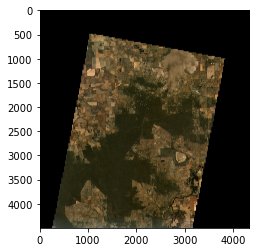

In [16]:
arr_rgb, dmin, dmax = utils.rgb_render(bands, bands=[2,1,0], 
                                 dmin=np.array([0., 0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Reading to xarray Dataset

The ```xarray``` library provides a nice decoration of ```numpy``` arrays for even more abstraction:

In [17]:
xrds = dataset.read_as_xarray(venus.Venus.GROUP_5M)

In [18]:
print(xrds)

<xarray.Dataset>
Dimensions:  (t: 1, x: 4338, y: 4496)
Coordinates:
  * t        (t) datetime64[ns] 2020-01-02
  * x        (x) float64 3.016e+05 3.017e+05 3.017e+05 ... 3.45e+05 3.45e+05
  * y        (y) float64 5.965e+06 5.965e+06 5.965e+06 ... 5.92e+06 5.92e+06
Data variables:
    B1       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    B2       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B3       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B4       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B5       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B6    

The created datasets contains several variables, with the requested bands and masks:

In [19]:
xrds.data_vars

Data variables:
    B1       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    B2       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B3       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B4       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B5       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B6       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B7       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B8       (t, y, x) float32 -10.0 -10.0 -10.0 -10.0 ... -10.0 -10.0 -10.0
    B9       (t, y, x) float32 -10.0 -10.0 -

Those variables are indexed with 3 sets of coordinates: x coordinates, y coordinates and time coordinates:

In [20]:
xrds.coords

Coordinates:
  * t        (t) datetime64[ns] 2020-01-02
  * x        (x) float64 3.016e+05 3.017e+05 3.017e+05 ... 3.45e+05 3.45e+05
  * y        (y) float64 5.965e+06 5.965e+06 5.965e+06 ... 5.92e+06 5.92e+06

The time coordinate has only a single value (since a dataset represents one acquisition date) but it would be very easy to stack several datasets together along the time dimension.

It is rather easy to use ```xarray``` to derive new variables:

In [21]:
ndvi = (xrds.B8-xrds.B4)/(1e-6 + xrds.B8 + xrds.B4)
print(ndvi)

<xarray.DataArray (t: 1, y: 4496, x: 4338)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2020-01-02
  * x        (x) float64 3.016e+05 3.017e+05 3.017e+05 ... 3.45e+05 3.45e+05
  * y        (y) float64 5.965e+06 5.965e+06 5.965e+06 ... 5.92e+06 5.92e+06


Of course, one can always access the underlying ```numpy``` arrays:

In [22]:
ndvi.values

array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]], dtype=float32)

# Advanced read

In this section, examples will be demonstrated with ```read_as_xarray(...)``` but one can achieve similar operations with ```read_as_numpy(...)```.

## Reading a spatial subset

The ```region``` argument allows to read a spatial subset of the data by providing ```(startx, starty, endx, endy)``` integer pixel coordinates tuple. Beware that those coordinates relate to the coordinates in the array after resampling or reprojection, and not input image coordinates.

In [23]:
print(dataset.read_as_xarray(venus.Venus.GROUP_5M, 
                             region=(1000,1000,1200,1200)))

<xarray.Dataset>
Dimensions:  (t: 1, x: 200, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2020-01-02
  * x        (x) float64 3.116e+05 3.117e+05 3.117e+05 ... 3.136e+05 3.136e+05
  * y        (y) float64 5.955e+06 5.955e+06 5.955e+06 ... 5.953e+06 5.953e+06
Data variables:
    B1       (t, y, x) float32 0.025 0.022 0.029 0.027 ... 0.079 0.083 0.088
    SAT      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CLM      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    EDG      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    MG2      (t, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    B2       (t, y, x) float32 0.041 0.04 0.044 0.043 ... 0.13 0.126 0.121 0.121
    B3       (t, y, x) float32 0.046 0.041 0.045 0.048 ... 0.162 0.157 0.158
    B4       (t, y, x) float32 0.061 0.057 0.06 0.061 ... 0.226 0.218 0.219
    B5       (t, y, x) float32 0.069 0.065 0.07 0.072 ... 0.295 0.286 0.28 0.281
 

The ```region``` argument also accepts a ```rio.coords.BoundingBox``` object representing a geo-referenced bounding-box in the given ```crs``` (default to input image ```crs```):

In [24]:
georoi = rio.coords.BoundingBox(399960.0, 4690200.0, 401960.0, 4692200.0) # left, bottom, right, top

In [25]:
print(dataset.read_as_xarray(venus.Venus.GROUP_5M,
                             region=georoi))

<xarray.Dataset>
Dimensions:  (t: 1, x: 0, y: 0)
Coordinates:
  * t        (t) datetime64[ns] 2020-01-02
  * x        (x) float64 
  * y        (y) float64 
Data variables:
    B1       (t, y, x) float32 
    SAT      (t, y, x) uint8 
    CLM      (t, y, x) uint8 
    EDG      (t, y, x) uint8 
    MG2      (t, y, x) uint8 
    B2       (t, y, x) float32 
    B3       (t, y, x) float32 
    B4       (t, y, x) float32 
    B5       (t, y, x) float32 
    B6       (t, y, x) float32 
    B7       (t, y, x) float32 
    B8       (t, y, x) float32 
    B9       (t, y, x) float32 
    B10      (t, y, x) float32 
    B11      (t, y, x) float32 
    B12      (t, y, x) float32 
Attributes:
    site:     GERAWH-1
    type:     FRE
    crs:      EPSG:32755


## Changing projection and sampling grid

The ```crs``` argument allows to resample the data into a different Coordinates Reference System  upon reading:

In [ ]:
print(dataset.read_as_xarray(venus.Venus.GROUP_5M, crs='epsg:2154')) # Lambert93 EPSG code

One can also change the image sampling grid by overloading the geographic bounds:

In [ ]:
newbounds = rio.coords.BoundingBox(399965.0, 4690205.0, 401965.0, 4692205.0) # left, bottom, right, top

In [ ]:
print(dataset.read_as_xarray(venus.Venus.GROUP_5M, bounds=newbounds))

***Note:*** This is different from using the region keyword which only does a subsetting. The ```bounds``` argument allows to modify the image sampling grid to match the grid of another image for instance.